In [ ]:
import os, re
import pandas as pd
from datetime import datetime, timedelta
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
import json

# ============================================================================
# CONFIGURATION
# ============================================================================
DATA_DIR = "data/4-02042025"
LAT, LON = 11.406172, 105.397017  # Boueng Sne, Cambodia
TARGET_SPECIES = []
MAX_FILES = 10  # Remove limit for production run

def parse_filename(fname):
    """
    Parse: 4_S7902_20250204_090000(UTC+7).wav
    Returns: (site_id, sensor_id, datetime_utc, datetime_local)
    """
    # Match pattern with UTC offset
    m = re.match(r"(\d+)_S(\d+)_(\d{8})_(\d{6})\(UTC([+-]\d+)\)", fname)
    if not m:
        print(f"⚠️  Skipping malformed filename: {fname}")
        return None
    
    site, sensor, datestr, timestr, utc_offset = m.groups()
    
    # Parse the local time from filename
    dt_local = datetime.strptime(datestr + timestr, "%Y%m%d%H%M%S")
    
    # Convert to UTC by subtracting the offset
    offset_hours = int(utc_offset)
    dt_utc = dt_local - timedelta(hours=offset_hours)
    
    return {
        "site_id": int(site),
        "sensor_id": int(sensor),
        "datetime_local": dt_local,
        "datetime_utc": dt_utc,
        "utc_offset": offset_hours
    }

# ============================================================================
# TEST THE PARSER
# ============================================================================
test_file = "3_S7901_20250204_091500(UTC+7)"
parsed = parse_filename(test_file)
print(f"📝 Test parse: {test_file}")
print(f"   Local time: {parsed['datetime_local']}")
print(f"   UTC time:   {parsed['datetime_utc']}")
print(f"   Offset:     UTC{parsed['utc_offset']:+d}\n")

# ============================================================================
# BIRDNET PROCESSING PIPELINE
# ============================================================================
analyzer = Analyzer()
records = []

print(f"🔊 Processing audio files from {DATA_DIR}...\n")

for i, file in enumerate(sorted(os.listdir(DATA_DIR))[:MAX_FILES]):
    if not file.endswith(".wav"):
        continue
    
    meta = parse_filename(file)
    if not meta:
        continue
    
    wav_path = os.path.join(DATA_DIR, file)
    
    print(f"[{i+1}/{MAX_FILES}] Processing {file}...")
    
    # BirdNET expects local datetime
    rec = Recording(
        analyzer,
        wav_path,
        lat=LAT,
        lon=LON,
        date=meta["datetime_local"],  # Use local time for BirdNET
        min_conf=0.25,  # Increased from 0.1 to reduce false positives
        # species_list=TARGET_SPECIES  # Uncomment when list ready
    )
    rec.analyze()
    
    # Store each detection
    for d in rec.detections:
        records.append({
            "site_id": meta["site_id"],
            "sensor_id": meta["sensor_id"],
            "datetime_local": meta["datetime_local"],
            "species_common": d["common_name"],
            "species_scientific": d["scientific_name"],
            "confidence": d["confidence"],
            "start_time_sec": d["start_time"],
            "end_time_sec": d["end_time"],
            "detection_duration_sec": d["end_time"] - d["start_time"],
            "lat": LAT,
            "lon": LON,
            "file_name": file,
            "model": "BirdNET"
        })
    
    print(f"   ✓ Found {len(rec.detections)} detections\n")

# ============================================================================
# CREATE DATAFRAME & SAVE
# ============================================================================
df = pd.DataFrame(records)

if len(df) > 0:
    # Add useful derived columns
    df['date'] = df['datetime_local'].dt.date
    df['hour'] = df['datetime_local'].dt.hour
    df['detection_start_absolute'] = df['datetime_local'] + pd.to_timedelta(df['start_time_sec'], unit='s')
    
    # Sort by time
    df = df.sort_values(['datetime_local', 'start_time_sec']).reset_index(drop=True)
    
    # Save
    df.to_csv("detections_birdnet.csv", index=False)
    print(f"✅ Saved {len(df)} detections to detections_birdnet.csv")
    print(f"📊 Found {df['species_common'].nunique()} unique species")
    print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"🕐 Time range: {df['hour'].min()}:00 to {df['hour'].max()}:00")
    print("\n" + "="*60)
    print("TOP 10 MOST DETECTED SPECIES:")
    print(df['species_common'].value_counts().head(10))
else:
    print("⚠️  No detections found!")

df.head(10)

/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📝 Test parse: 4_S7902_20250204_090000(UTC+7).wav
   Local time: 2025-02-04 09:00:00
   UTC time:   2025-02-04 02:00:00
   Offset:     UTC+7

Labels loaded.
load model True


/Users/ahmed/Desktop/boeung-sne/birdc/lib/python3.9/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: 

Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
🔊 Processing audio files from data/4-02042025...

[1/10] Processing 4_S7902_20250204_090000(UTC+7).wav...
read_audio_data


Created TensorFlow Lite XNNPACK delegate for CPU.


read_audio_data: complete, read  200 chunks.
analyze_recording 4_S7902_20250204_090000(UTC+7).wav
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
5
511 species loaded.
   ✓ Found 31 detections

[2/10] Processing 4_S7902_20250204_091500(UTC+7).wav...
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 4_S7902_20250204_091500(UTC+7).wav
recording has lon/lat
set_predicted_species_list_from_position
   ✓ Found 44 detections

[3/10] Processing 4_S7902_20250204_093000(UTC+7).wav...
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 4_S7902_20250204_093000(UTC+7).wav
recording has lon/lat
set_predicted_species_list_from_position
   ✓ Found 19 detections

[4/10] Processing 4_S7902_20250204_094500(UTC+7).wav...
read_audio_data
read_audio_data: complete, read  200 chunks.
analyze_recording 4_S7902_20250204_094500(UTC+7).wav
recording has lon/lat
set_predicted_species_list_from_position
   ✓ Found

,site_id,sensor_id,datetime_local,datetime_utc,utc_offset,species_common,species_scientific,confidence,start_time_sec,end_time_sec,detection_duration_sec,lat,lon,file_name,model,date,hour,detection_start_absolute
0,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Cattle Egret,Bubulcus ibis,0.299693,15.0,18.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:00:15
1,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Cattle Egret,Bubulcus ibis,0.664484,30.0,33.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:00:30
2,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Cattle Egret,Bubulcus ibis,0.281571,36.0,39.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:00:36
3,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Great Cormorant,Phalacrocorax carbo,0.349634,57.0,60.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:00:57
4,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Cattle Egret,Bubulcus ibis,0.264894,60.0,63.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:01:00
5,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Cattle Egret,Bubulcus ibis,0.631362,63.0,66.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:01:03
6,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Great Cormorant,Phalacrocorax carbo,0.267220,87.0,90.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:01:27
7,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Great Cormorant,Phalacrocorax carbo,0.548530,102.0,105.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:01:42
8,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Great Cormorant,Phalacrocorax carbo,0.360687,120.0,123.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:02:00
9,4,7902,2025-02-04 09:00:00,2025-02-04 02:00:00,7,Great Cormorant,Phalacrocorax carbo,0.678895,123.0,126.0,3.0,11.406172,105.397017,4_S7902_20250204_090000(UTC+7).wav,BirdNET,2025-02-04,9,2025-02-04 09:02:03


In [11]:
# ============================================================================
# ECOLOGICAL INSIGHTS EXTRACTION
# ============================================================================

def extract_insights(df):
    """
    Extract ecological insights from detection dataframe
    """
    insights = {}
    
    # 1. SPECIES RICHNESS
    insights['total_species'] = df['species_common'].nunique()
    insights['species_list'] = sorted(df['species_common'].unique())
    
    # 2. DETECTION FREQUENCY (calls per hour)
    total_recording_hours = df['file_name'].nunique() * 0.25  # 15min = 0.25hr
    insights['detections_per_hour'] = len(df) / total_recording_hours
    
    # 3. TEMPORAL ACTIVITY PATTERNS
    insights['hourly_activity'] = df.groupby('hour').size().to_dict()
    insights['peak_activity_hour'] = df.groupby('hour').size().idxmax()
    
    # 4. DOMINANT SPECIES (>10% of detections)
    species_counts = df['species_common'].value_counts()
    total_detections = len(df)
    insights['dominant_species'] = species_counts[species_counts > total_detections * 0.1].to_dict()
    
    # 5. RARE SPECIES (single detection or <1%)
    insights['rare_species'] = species_counts[species_counts < max(2, total_detections * 0.01)].to_dict()
    
    # 6. CALL DENSITY (detections per recording)
    insights['avg_detections_per_recording'] = df.groupby('file_name').size().mean()
    insights['max_detections_per_recording'] = df.groupby('file_name').size().max()
    
    # 7. HIGH CONFIDENCE DETECTIONS (>0.9)
    high_conf = df[df['confidence'] > 0.9]
    insights['high_confidence_species'] = high_conf['species_common'].value_counts().head(10).to_dict()
    
    # 8. ASIAN OPENBILL SPECIFIC (your ground truth species)
    openbills = df[df['species_common'].str.contains('Openbill', case=False, na=False)]
    insights['asian_openbill_detections'] = len(openbills)
    insights['asian_openbill_avg_confidence'] = openbills['confidence'].mean() if len(openbills) > 0 else 0
    
    return insights

# Run analysis
insights = extract_insights(df)

print("="*60)
print("🔬 ECOLOGICAL INSIGHTS")
print("="*60)
print(f"\n📊 SPECIES DIVERSITY:")
print(f"   Total species detected: {insights['total_species']}")
print(f"   Dominant species: {list(insights['dominant_species'].keys())}")
print(f"   Rare species: {list(insights['rare_species'].keys())[:5]}...")

print(f"\n⏰ TEMPORAL PATTERNS:")
print(f"   Peak activity hour: {insights['peak_activity_hour']}:00")
print(f"   Detections per hour: {insights['detections_per_hour']:.1f}")

print(f"\n🎯 ASIAN OPENBILL (Ground Truth Species):")
print(f"   Detections: {insights['asian_openbill_detections']}")
print(f"   Avg confidence: {insights['asian_openbill_avg_confidence']:.3f}")

print(f"\n✅ HIGH CONFIDENCE DETECTIONS (>0.9):")
for species, count in list(insights['high_confidence_species'].items())[:5]:
    print(f"   {species}: {count}")


🔬 ECOLOGICAL INSIGHTS

📊 SPECIES DIVERSITY:
   Total species detected: 8
   Dominant species: ['Cattle Egret', 'Great Cormorant']
   Rare species: ['Brown Noddy', 'Arctic Warbler', 'Asian Openbill', 'House Sparrow']...

⏰ TEMPORAL PATTERNS:
   Peak activity hour: 9:00
   Detections per hour: 48.0

🎯 ASIAN OPENBILL (Ground Truth Species):
   Detections: 1
   Avg confidence: 0.271

✅ HIGH CONFIDENCE DETECTIONS (>0.9):
   Great Cormorant: 1
   Cattle Egret: 1


NameError: name 'files' is not defined

In [13]:
df['date'] = df['datetime_local'].dt.date
df['hour'] = df['datetime_local'].dt.hour
df['minute'] = df['datetime_local'].dt.minute
df['detection_start_absolute'] = df['datetime_local'] + pd.to_timedelta(df['start_time_sec'], unit='s')
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], 
                            labels=['Night', 'Morning', 'Afternoon', 'Evening'])


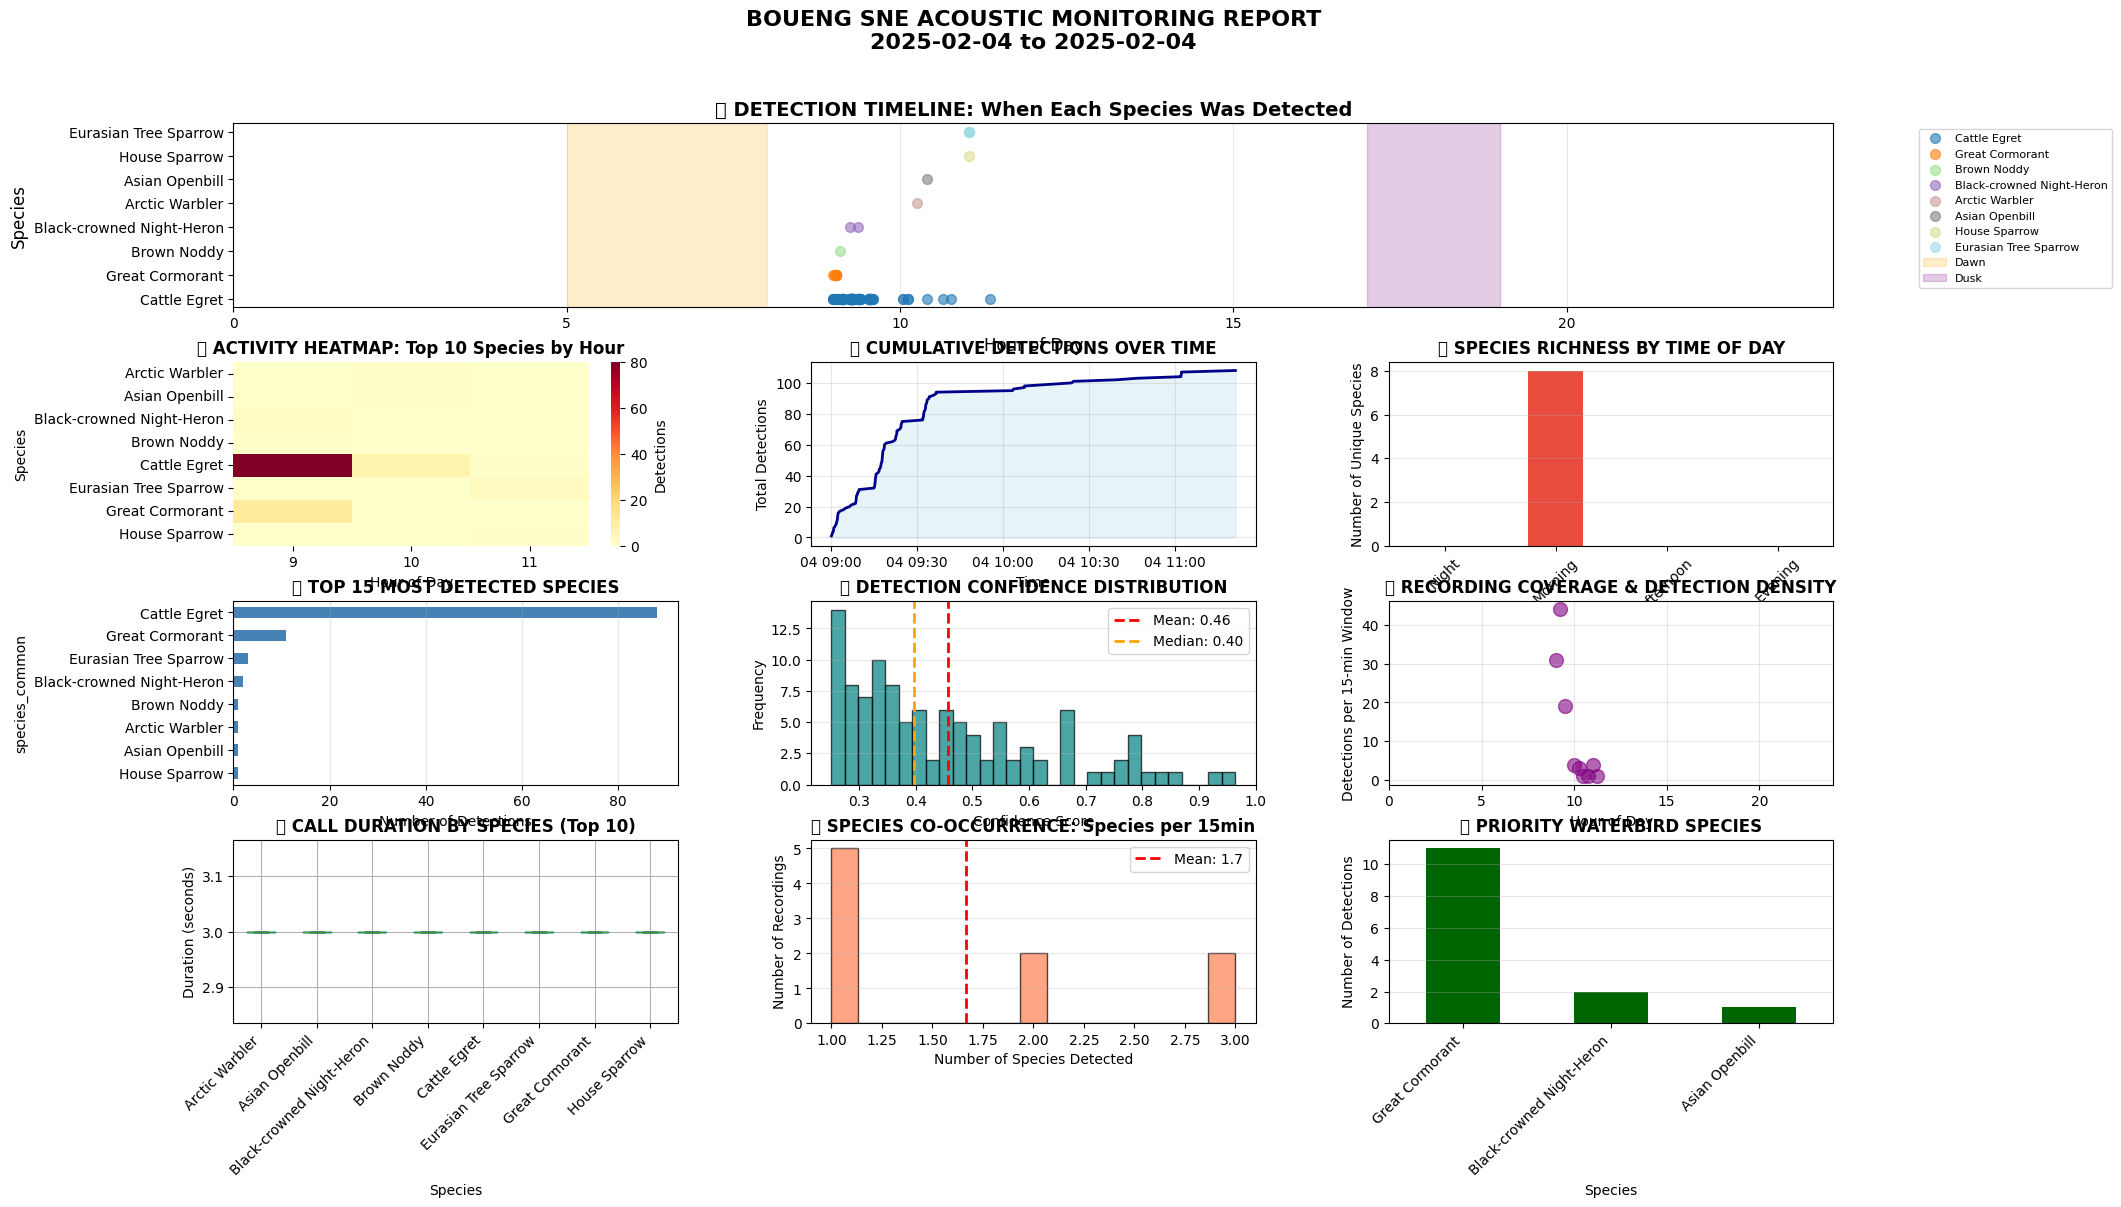


📋 ECOLOGICAL SUMMARY REPORT

📊 OVERALL STATISTICS:
   Total detections: 108
   Unique species: 8
   Recording sessions: 9
   Date range: 2025-02-04 to 2025-02-04
   Time coverage: 9:00 to 11:00

🕐 TEMPORAL PATTERNS:
   Peak activity hour: 9:00
   Average detections per recording: 12.0
   Most active time period: Morning

🐦 SPECIES DIVERSITY:
   Most detected: Cattle Egret (88 detections)
   Rare species (≤2 detections): 5

🎯 PRIORITY WATERBIRDS:
   Great Cormorant: 11 detections
   Black-crowned Night-Heron: 2 detections
   Asian Openbill: 1 detections

✅ DETECTION QUALITY:
   Mean confidence: 0.456
   High confidence (>0.9): 2 detections (1.9%)

💾 Saved detailed data to: detections_master.csv
💾 Saved visualization to: ecological_timeline_report.png


In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# ============================================================================
# 1. TIMELINE VIEW - When were birds detected throughout the day?
# ============================================================================
ax1 = fig.add_subplot(gs[0, :])

# Create timeline scatter
colors = plt.cm.tab20(np.linspace(0, 1, df['species_common'].nunique()))
species_colors = dict(zip(df['species_common'].unique(), colors))

for species in df['species_common'].unique()[:15]:  # Top 15 for clarity
    species_data = df[df['species_common'] == species]
    times = species_data['detection_start_absolute'].apply(lambda x: x.hour + x.minute/60)
    ax1.scatter(times, [species]*len(times), 
               alpha=0.6, s=50, label=species, 
               c=[species_colors[species]])

ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Species', fontsize=12)
ax1.set_title('🕐 DETECTION TIMELINE: When Each Species Was Detected', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 24)
ax1.grid(True, alpha=0.3, axis='x')
ax1.axvspan(5, 8, alpha=0.2, color='orange', label='Dawn')
ax1.axvspan(17, 19, alpha=0.2, color='purple', label='Dusk')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# ============================================================================
# 2. HOURLY ACTIVITY HEATMAP
# ============================================================================
ax2 = fig.add_subplot(gs[1, 0])

hourly_species = df.groupby(['hour', 'species_common']).size().reset_index(name='count')
top_species = df['species_common'].value_counts().head(10).index
hourly_pivot = hourly_species[hourly_species['species_common'].isin(top_species)].pivot(
    index='species_common', columns='hour', values='count'
).fillna(0)

sns.heatmap(hourly_pivot, cmap='YlOrRd', annot=False, fmt='g', 
            cbar_kws={'label': 'Detections'}, ax=ax2)
ax2.set_title('🔥 ACTIVITY HEATMAP: Top 10 Species by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Species')

# ============================================================================
# 3. DETECTION DENSITY OVER TIME
# ============================================================================
ax3 = fig.add_subplot(gs[1, 1])

df_sorted = df.sort_values('detection_start_absolute')
df_sorted['cumulative'] = range(1, len(df_sorted) + 1)
ax3.plot(df_sorted['detection_start_absolute'], df_sorted['cumulative'], 
         linewidth=2, color='darkblue')
ax3.fill_between(df_sorted['detection_start_absolute'], 0, df_sorted['cumulative'], 
                  alpha=0.3, color='lightblue')
ax3.set_title('📈 CUMULATIVE DETECTIONS OVER TIME', fontweight='bold')
ax3.set_xlabel('Time')
ax3.set_ylabel('Total Detections')
ax3.grid(True, alpha=0.3)

# ============================================================================
# 4. SPECIES RICHNESS BY TIME OF DAY
# ============================================================================
ax4 = fig.add_subplot(gs[1, 2])

richness_by_time = df.groupby('time_of_day')['species_common'].nunique()
colors_tod = ['#2C3E50', '#E74C3C', '#F39C12', '#8E44AD']
richness_by_time.plot(kind='bar', ax=ax4, color=colors_tod)
ax4.set_title('🌅 SPECIES RICHNESS BY TIME OF DAY', fontweight='bold')
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Number of Unique Species')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 5. TOP SPECIES ABUNDANCE
# ============================================================================
ax5 = fig.add_subplot(gs[2, 0])

top_15 = df['species_common'].value_counts().head(15)
top_15.plot(kind='barh', ax=ax5, color='steelblue')
ax5.set_title('🐦 TOP 15 MOST DETECTED SPECIES', fontweight='bold')
ax5.set_xlabel('Number of Detections')
ax5.invert_yaxis()
ax5.grid(True, alpha=0.3, axis='x')

# ============================================================================
# 6. CONFIDENCE DISTRIBUTION
# ============================================================================
ax6 = fig.add_subplot(gs[2, 1])

ax6.hist(df['confidence'], bins=30, edgecolor='black', color='teal', alpha=0.7)
ax6.axvline(df['confidence'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["confidence"].mean():.2f}')
ax6.axvline(df['confidence'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f'Median: {df["confidence"].median():.2f}')
ax6.set_title('📊 DETECTION CONFIDENCE DISTRIBUTION', fontweight='bold')
ax6.set_xlabel('Confidence Score')
ax6.set_ylabel('Frequency')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 7. RECORDING COVERAGE (Which times were actually recorded?)
# ============================================================================
ax7 = fig.add_subplot(gs[2, 2])

recording_times = df.groupby(['hour', 'minute']).size().reset_index(name='count')
ax7.scatter(recording_times['hour'] + recording_times['minute']/60, 
           recording_times['count'], s=100, alpha=0.6, color='purple')
ax7.set_title('📻 RECORDING COVERAGE & DETECTION DENSITY', fontweight='bold')
ax7.set_xlabel('Hour of Day')
ax7.set_ylabel('Detections per 15-min Window')
ax7.set_xlim(0, 24)
ax7.grid(True, alpha=0.3)

# ============================================================================
# 8. CALL DURATION ANALYSIS
# ============================================================================
ax8 = fig.add_subplot(gs[3, 0])

df['call_duration'] = df['end_time_sec'] - df['start_time_sec']
top_species_duration = df['species_common'].value_counts().head(10).index
duration_data = df[df['species_common'].isin(top_species_duration)]

duration_data.boxplot(column='call_duration', by='species_common', ax=ax8)
ax8.set_title('⏱️ CALL DURATION BY SPECIES (Top 10)', fontweight='bold')
ax8.set_xlabel('Species')
ax8.set_ylabel('Duration (seconds)')
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('')  # Remove default title

# ============================================================================
# 9. MULTI-SPECIES OVERLAP (How often do species co-occur?)
# ============================================================================
ax9 = fig.add_subplot(gs[3, 1])

# Count how many species per recording
species_per_recording = df.groupby('file_name')['species_common'].nunique()
ax9.hist(species_per_recording, bins=15, edgecolor='black', color='coral', alpha=0.7)
ax9.set_title('🦜 SPECIES CO-OCCURRENCE: Species per 15min', fontweight='bold')
ax9.set_xlabel('Number of Species Detected')
ax9.set_ylabel('Number of Recordings')
ax9.axvline(species_per_recording.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {species_per_recording.mean():.1f}')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

# ============================================================================
# 10. PRIORITY SPECIES TRACKER
# ============================================================================
ax10 = fig.add_subplot(gs[3, 2])

# Focus on your priority species
priority_keywords = ['Openbill', 'Stork', 'Ibis', 'Cormorant', 'Heron']
priority_detections = df[df['species_common'].str.contains('|'.join(priority_keywords), 
                                                            case=False, na=False)]
if len(priority_detections) > 0:
    priority_counts = priority_detections['species_common'].value_counts()
    priority_counts.plot(kind='bar', ax=ax10, color='darkgreen')
    ax10.set_title(' PRIORITY WATERBIRD SPECIES', fontweight='bold')
    ax10.set_xlabel('Species')
    ax10.set_ylabel('Number of Detections')
    ax10.set_xticklabels(ax10.get_xticklabels(), rotation=45, ha='right')
    ax10.grid(True, alpha=0.3, axis='y')
else:
    ax10.text(0.5, 0.5, 'No priority species detected', 
             ha='center', va='center', fontsize=12)
    ax10.set_title('🎯 PRIORITY WATERBIRD SPECIES', fontweight='bold')

plt.suptitle(f'BOUENG SNE ACOUSTIC MONITORING REPORT\n{df["date"].min()} to {df["date"].max()}', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('ecological_timeline_report.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("📋 ECOLOGICAL SUMMARY REPORT")
print("="*70)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Total detections: {len(df):,}")
print(f"   Unique species: {df['species_common'].nunique()}")
print(f"   Recording sessions: {df['file_name'].nunique()}")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   Time coverage: {df['hour'].min()}:00 to {df['hour'].max()}:00")

print(f"\n🕐 TEMPORAL PATTERNS:")
print(f"   Peak activity hour: {df.groupby('hour').size().idxmax()}:00")
print(f"   Average detections per recording: {len(df) / df['file_name'].nunique():.1f}")
print(f"   Most active time period: {df.groupby('time_of_day').size().idxmax()}")

print(f"\n🐦 SPECIES DIVERSITY:")
print(f"   Most detected: {df['species_common'].value_counts().index[0]} ({df['species_common'].value_counts().iloc[0]} detections)")
print(f"   Rare species (≤2 detections): {len(df['species_common'].value_counts()[df['species_common'].value_counts() <= 2])}")

print(f"\n🎯 PRIORITY WATERBIRDS:")
if len(priority_detections) > 0:
    for species, count in priority_detections['species_common'].value_counts().head(5).items():
        print(f"   {species}: {count} detections")
else:
    print("   No priority species detected")

print(f"\n✅ DETECTION QUALITY:")
print(f"   Mean confidence: {df['confidence'].mean():.3f}")
print(f"   High confidence (>0.9): {(df['confidence'] > 0.9).sum()} detections ({(df['confidence'] > 0.9).sum()/len(df)*100:.1f}%)")


df.to_csv('detections_master.csv', index=False)
print(f"\n💾 Saved detailed data to: detections_master.csv")
print(f"💾 Saved visualization to: ecological_timeline_report.png")